In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections

%matplotlib inline

# Plot Setting

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Functions

In [3]:
# Train Inputs
def get_train_inputs():
    x = tf.constant(X_train)
    y = tf.constant(y_train)
    return x, y

# Test Inputs
def get_test_inputs():
    x = tf.constant(X_test)
    y = tf.constant(y_test)
    return x, y

# Eval data
def get_eval_data():
    return tf.constant(X_test)

# Plot matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Comment

### Arrhythmia Type List
- N = 'N', 'L', 'R', 'e', 'j'
- SVEB = 'A', 'a', 'J', 'S'
- VEB = 'V', 'E'
- F = 'F'
- Q = '/', 'f'

### Arrhythmia Annotation
- N = Normal beat
- L = Left bundle branch block beat
- R = Right bundle branch block beat
- e = Atrial escape beat
- j = Nodal (junctional) escape beat
- A = Atrial premature beat
- a = Aberrated atrial premature beat
- J = Nodal (junctional) premature beat
- S = Supraventricular premature or ectopic beat (atrial or nodal)
- V = Premature ventricular contraction
- E = Ventricular escape beat
- F = Fusion of ventricular and normal beat
- / = Paced beat
- f = Fusion of paced and normal beat

### The Number of Each Arrhythmia Type
- N = 10001
- L = 8075
- R = 7259
- e = 16
- j = 229
- A = 2546
- a = 150
- J = 83
- S = 2
- V = 7130
- E = 106
- F = 803
- / = 7028
- f = 982

**So I take types(N, L, R, A, V, /) because quantity of others are not suitable.**

# Read Dataset

In [4]:
# Variables

path = 'mitDB/'
window_size = 160
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V', '/']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

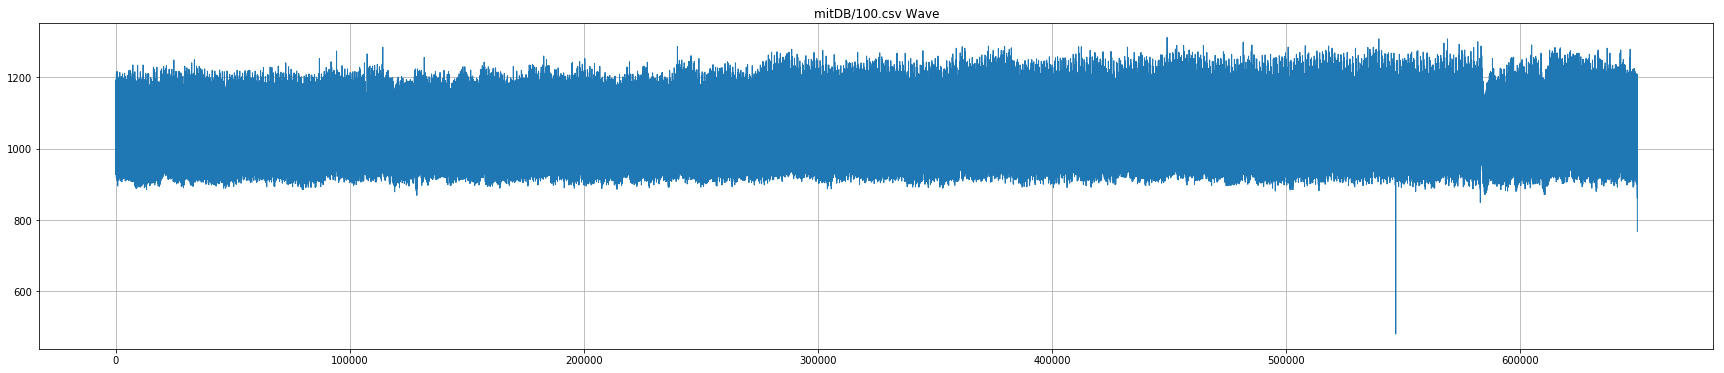

In [5]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
    
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 0:
        # Plot each patient's signal
        plt.title(records[0] + " Wave")
        plt.plot(signals)
        plt.show()

    # Read anotations: R position and Arrhythmia class
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type

            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                    pass
                else:
                    count_classes[arrhythmia_index] += 1
                    if(window_size < pos and pos < (len(signals) - window_size)):
                        beat = signals[pos-window_size+1:pos+window_size]
                        X.append(beat)
                        y.append(arrhythmia_index)
                        
# np.shape(X) => (42021, 319)
# np.shape(y) => (42021, )

# Training & Test

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))

X_train :  28154
X_test  :  13867
y_train :  Counter({0: 6712, 1: 5395, 2: 4881, 4: 4780, 5: 4722, 3: 1664})
y_test  :  Counter({0: 3285, 1: 2676, 2: 2374, 4: 2349, 5: 2301, 3: 882})


In [7]:
print(np.shape(X_train[0]))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(319,)
(28154,)
(13867, 319)
(13867,)


In [8]:
# Normalize
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')

# Specify that all features have real-value data
feature_columns = [tf.feature_column.numeric_column("ecg", shape=np.shape(X_train[0]))]

# Build Classifier
estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=n_classes,
    optimizer=tf.train.FtrlOptimizer(
      learning_rate=0.1,
      l1_regularization_strength=0.001
    )
)

# Train model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(X_train)},
    y=np.array(y_train),
    batch_size=100,
    num_epochs=1000,
    shuffle=True
)

estimator.train(input_fn=train_input_fn, steps=10000)

# Evaluate accuracy
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(X_test)},
    y=np.array(y_test),
    batch_size=10,
    num_epochs=1,
    shuffle=False
)

accuracy_score = estimator.evaluate(input_fn=test_input_fn)["accuracy"]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_train_distribute': None, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_is_chief': True, '_master': '', '_save_checkpoints_secs': 600, '_model_dir': 'C:\\Users\\soma06\\AppData\\Local\\Temp\\tmpb6i8w81t', '_evaluation_master': '', '_save_checkpoints_steps': None, '_device_fn': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000146BC90D2E8>, '_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_task_type': 'worker', '_log_step_count_steps': 100, '_task_id': 0, '_service': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 in

In [9]:
# Predict
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(X_test)},
    shuffle=False
)

predictions = estimator.predict(input_fn=pred_input_fn)

# Plot Confusion Matrix

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\soma06\AppData\Local\Temp\tmpb6i8w81t\model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Test Accuracy: 51.705486%

Normalized confusion matrix


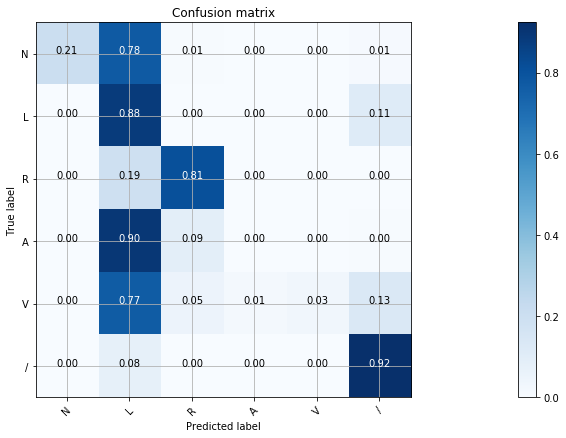

In [10]:
pred = list()
for p in predictions:
    pred.append(p["class_ids"][0])
    
cm = confusion_matrix(y_test, pred)

print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))
plot_confusion_matrix(cm, classes, normalize=True)